In [18]:
import numpy as np
from torch.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import torch
import tqdm

# viewimage
import tempfile
import IPython
from skimage.transform import rescale

import utils
from utils import str2, psnr

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def gmm_density_heatmap(density, *args):
    """
    Plots a heatmap of the unnormalized density function.
    ----------
    Parameters
    density : The density function.
    *args : The parameters of the density function.
    """
    mus, sigmas, alphas = args
    x_grid, y_grid = np.meshgrid(np.linspace(-5, 15, 100), np.linspace(-5, 15, 100))
    z_grid = np.empty(x_grid.shape)
    for i in range(x_grid.shape[0]):
        for j in range(x_grid.shape[1]):
            x = np.array([x_grid[i, j], y_grid[i, j]])
            z_grid[i, j] = density(x, mus, sigmas, alphas)
    plt.contourf(x_grid, y_grid, z_grid, levels=100)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Unnormalized Gaussian mixture density')
    plt.show()

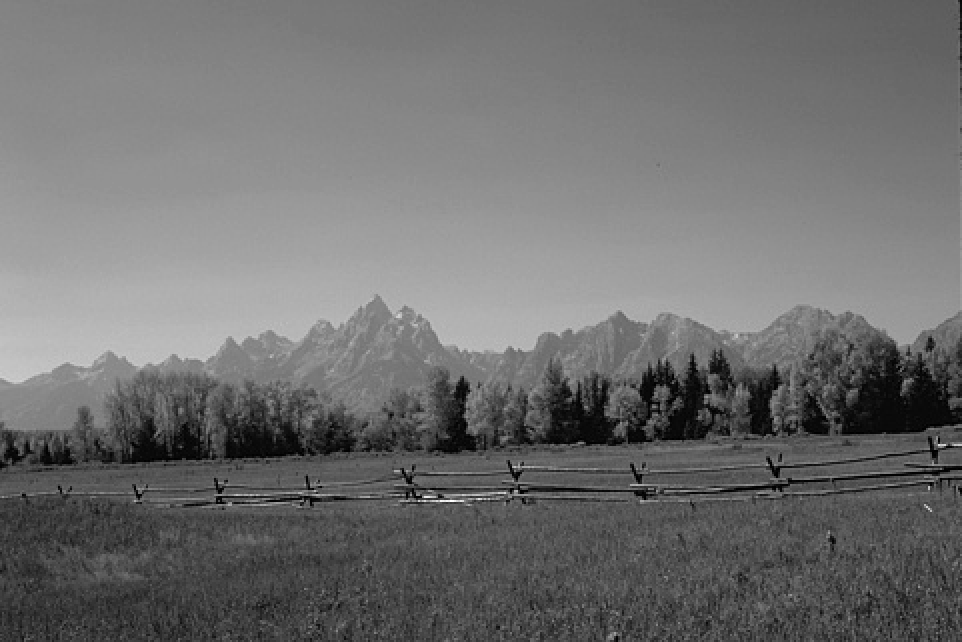

In [5]:
x = torch.tensor(utils.rgb2gray(plt.imread('data/train/2092.jpg')))
M,N = x.shape

utils.viewimage(x)

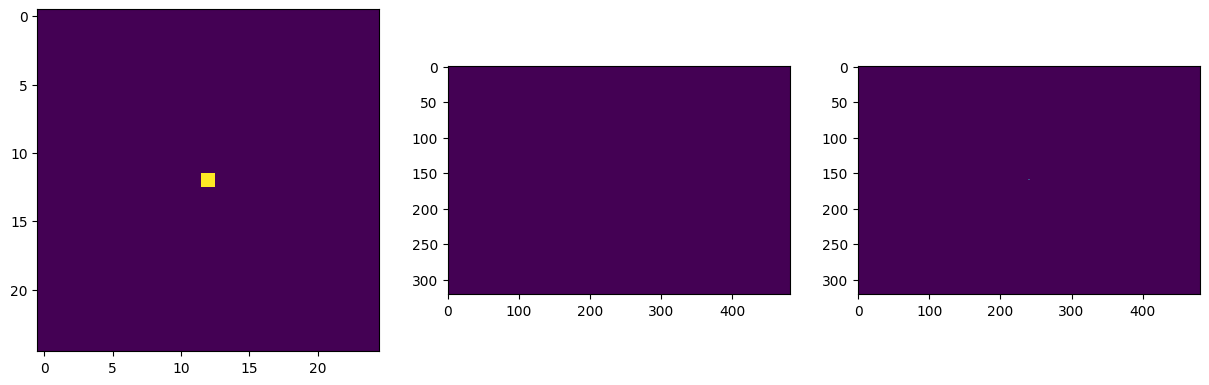

In [6]:
kt = torch.tensor(np.loadtxt('kernels/kernel0.txt'))
(m,n) = kt.shape
kt = torch.zeros((m,n))
kt[12,12] = 1
# Embed the kernel in a MxN image, and put center at pixel (0,0)
k = torch.zeros((M,N))
k[0:m,0:n] = kt/torch.sum(kt)
k = torch.roll(k,(-int(m/2),-int(n/2)),(0,1)) # periodic translation
fk = fft2(k)

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(kt)
# ax[0].set_title('Original kernel - Identity')
ax[1].imshow(k)
ax[2].imshow(fftshift(k))
plt.show()

In [11]:
# Parameters
sigma = 15. / 255.

lam = 0.15
lr = 1.9 / (1 + 16 * (1/lam))  # 1.9 so that < to 2/L (L = 1+16*lambda)

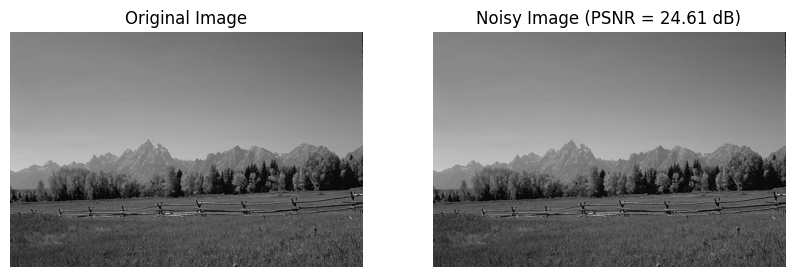

In [12]:
# Degradation
z = utils.forward_operator(x, k) + torch.randn((M, N)) * sigma

fig, ax = plt.subplots(1, 2, figsize=(10,5), dpi=100)
ax[0].imshow(x,cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(z,cmap='gray')
ax[1].set_title('Noisy Image (PSNR = ' + str2(psnr(x,z)) + ' dB)')
ax[1].axis('off')
plt.show()

In [17]:
# Test unadjusted Langevin dynamics

energies, chain_iterates = utils.unadjusted_langevin_dynamics_TVSmoothed(z, sigma=sigma, k=k, lambda_=lam, 
                                                                         eps=1e-3, tau=1e-3, niter=2000)

plt.plot(energies)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy of the chain')
plt.show()

TypeError: unadjusted_langevin_dynamics_TVSmoothed() got an unexpected keyword argument 'k'